In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip

--2023-04-12 11:06:34--  https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66764119 (64M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  63.67M  93.4MB/s    in 0.7s    

2023-04-12 11:06:35 (93.4 MB/s) - ‘Dataset.zip’ saved [66764119/66764119]



In [3]:
!mkdir dataset

In [4]:
!unzip /content/Dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/mnist_middle_columns/26957.jpg  
  inflating: /content/dataset/mnist_middle_columns/83.csv  
  inflating: /content/dataset/mnist_middle_columns/4921.csv  
  inflating: /content/dataset/mnist_middle_columns/34436.jpg  
  inflating: /content/dataset/mnist_middle_columns/28228.csv  
  inflating: /content/dataset/mnist_middle_columns/11910.csv  
  inflating: /content/dataset/mnist_middle_columns/24492.jpg  
  inflating: /content/dataset/mnist_middle_columns/32617.jpg  
  inflating: /content/dataset/mnist_middle_columns/57638.csv  
  inflating: /content/dataset/mnist_middle_columns/37617.csv  
  inflating: /content/dataset/mnist_middle_columns/35601.jpg  
  inflating: /content/dataset/mnist_middle_columns/42223.csv  
  inflating: /content/dataset/mnist_middle_columns/24519.csv  
  inflating: /content/dataset/mnist_middle_columns/40571.csv  
  inflating: /content/dataset/mnist_middle_columns/54769.jpg  
  inflat

In [5]:
import glob 
image_paths = glob.glob('/content/dataset/mnist_middle_columns/*.jpg')

In [6]:
image_paths[0]

'/content/dataset/mnist_middle_columns/39287.jpg'

In [7]:
len(image_paths)

60000

In [8]:
split_size = 0.8
train_size = int(split_size * len(image_paths))
train_paths = image_paths[:train_size]
valid_paths = image_paths[train_size:]
print(f'train size : {len(train_paths)}, test size : {len(valid_paths)}')

train size : 48000, test size : 12000


In [9]:
image = Image.open(image_paths[0])
image

In [10]:
image_array = np.array(image)
(image_array[:,:,0].all() == image_array[:,:,1].all() == image_array[:,:,2].all()).all()

True

In [11]:
csv_path = image_paths[0].replace('.jpg','.csv')
csv_path

'/content/dataset/mnist_middle_columns/39287.csv'

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image_array = np.array(image)
        image_array = image_array[:,:,0]
        image_array = image_array/255 # convert pixcel values between 0 and 1
        
        # flatten 2d image to 1d array
        image = image_array.reshape(28*28)
        image = torch.tensor(image)
        
        csv_path = image_path.replace('.jpg','.csv')
        df = pd.read_csv(csv_path)
        target = df['0'].values
        target = torch.tensor(target)

        return image.float(), target.float()
        

In [13]:
train_dataset = CustomImageDataset(train_paths)
valid_dateset = CustomImageDataset(valid_paths)

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dateset, batch_size=64, shuffle=True)

In [15]:
len(train_dataloader.dataset)

48000

In [16]:
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, bn = False, dropout = False, activation_func = nn.ReLU()):
    super(MLP, self).__init__()

    # number of hidden neurons in each layer
    hidden_1 = 512
    hidden_2 = 512
    self.bn = bn
    self.dropout = dropout
    self.activation_func = activation_func

    if self.bn == True and self.dropout == True:
      self.hidden_1 = nn.Linear(28 * 28, hidden_1) #input layer with 784 neuron 
      self.bn_1 = nn.BatchNorm1d(hidden_1) # batch normalization layer
      self.dropout_1 = nn.Dropout(p=0.2) # dropout layer

      self.hidden_2 = nn.Linear(hidden_1, hidden_2) #hidden layer ()
      self.bn_2 = nn.BatchNorm1d(hidden_2) # batch normalization layer
      self.dropout_2 = nn.Dropout(p=0.2) # dropout layer

      self.output = nn.Linear(hidden_2, 28) #output layer 

    elif self.bn == True and self.dropout == False:
      self.hidden_1 = nn.Linear(28 * 28, hidden_1) #input layer with 784 neuron 
      self.bn_1 = nn.BatchNorm1d(hidden_1) # batch normalization layer

      self.hidden_2 = nn.Linear(hidden_1, hidden_2) #hidden layer 
      self.bn_2 = nn.BatchNorm1d(hidden_2) # batch normalization layer

      self.output = nn.Linear(hidden_2, 28) #output layer

    elif self.bn == False and self.dropout == True:
      self.hidden_1 = nn.Linear(28 * 28, hidden_1) #input layer with 784 neuron 
      self.dropout_1 = nn.Dropout(p=0.2) # dropout layer

      self.hidden_2 = nn.Linear(hidden_1, hidden_2) #hidden layer 
      self.dropout_2 = nn.Dropout(p=0.2) # dropout layer

      self.output = nn.Linear(hidden_2, 28) #output layer

    else:
      self.hidden_1 = nn.Linear(28 * 28, hidden_1) #input layer with 784 neuron 
      self.hidden_2 = nn.Linear(hidden_1, hidden_2) #hidden layer 
      self.output = nn.Linear(hidden_2, 28) #output layer 

  def forward(self, x):
    x = x.to(torch.float32)
    x = x.view(-1, 28*28)

    if self.bn == True and self.dropout == True:
      x = self.bn_1(self.hidden_1(x))
      x = self.activation_func(x)
      x = self.dropout_1(x)

      x = self.bn_2(self.hidden_2(x))
      x = self.activation_func(x)
      x = self.dropout_2(x)

      x = self.output(x)

    elif self.bn == True and self.dropout == False:
      x = self.bn_1(self.hidden_1(x))
      x = self.activation_func(x)

      x = self.bn_2(self.hidden_2(x))
      x = self.activation_func(x)

      x = self.output(x)

    elif self.bn == False and self.dropout == True:
      x = self.hidden_1(x)
      x = self.activation_func(x)
      x = self.dropout_1(x)

      x = self.hidden_2(x)
      x = self.activation_func(x)
      x = self.dropout_2(x)

      x = self.output(x)

    else:
      x = self.hidden_1(x)
      x = self.activation_func(x)

      x = self.hidden_2(x)
      x = self.activation_func(x)

      x = self.output(x)

    return x

In [ ]:
model = MLP()
print(model)

MLP(
  (activation_func): ReLU()
  (hidden_1): Linear(in_features=784, out_features=512, bias=True)
  (hidden_2): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=28, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

In [ ]:
n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.049368 	Validation Loss: 0.030852
Validation loss decreased (inf --> 0.030852).  Saving model ...
Epoch: 2 	Training Loss: 0.027945 	Validation Loss: 0.026053
Validation loss decreased (0.030852 --> 0.026053).  Saving model ...
Epoch: 3 	Training Loss: 0.024586 	Validation Loss: 0.023531
Validation loss decreased (0.026053 --> 0.023531).  Saving model ...
Epoch: 4 	Training Loss: 0.022545 	Validation Loss: 0.021882
Validation loss decreased (0.023531 --> 0.021882).  Saving model ...
Epoch: 5 	Training Loss: 0.021116 	Validation Loss: 0.020652
Validation loss decreased (0.021882 --> 0.020652).  Saving model ...
Epoch: 6 	Training Loss: 0.020045 	Validation Loss: 0.019738
Validation loss decreased (0.020652 --> 0.019738).  Saving model ...
Epoch: 7 	Training Loss: 0.019210 	Validation Loss: 0.018989
Validation loss decreased (0.019738 --> 0.018989).  Saving model ...
Epoch: 8 	Training Loss: 0.018539 	Validation Loss: 0.018324
Validation loss decreased (0.01898

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
print(output.shape)

torch.Size([64, 28])


In [ ]:
data = data.reshape(64, 28, 28)
data.shape

torch.Size([64, 28, 28])

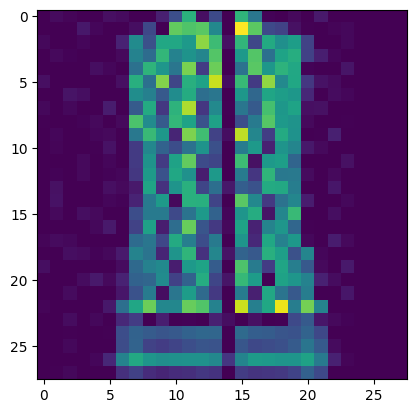

In [ ]:
plt.imshow(data[0, :, :].detach().numpy())

In [ ]:
data[0:, :, 14] = output[0, :]

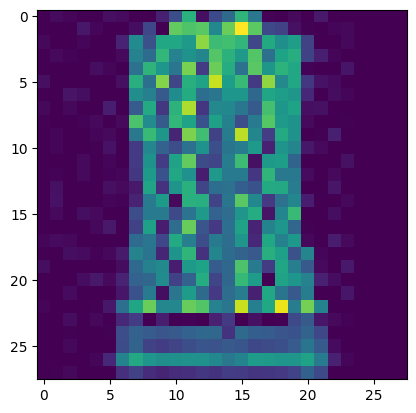

In [ ]:
plt.imshow(data[0, :, :].detach().numpy())
# plt.savefig("0.jpg")

# With Batch Normalization layers

In [ ]:
model = MLP(bn=True)
print(model)

MLP(
  (hidden_1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_2): Linear(in_features=512, out_features=512, bias=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=512, out_features=28, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.036926 	Validation Loss: 0.022293
Validation loss decreased (inf --> 0.022293).  Saving model ...
Epoch: 2 	Training Loss: 0.023105 	Validation Loss: 0.019394
Validation loss decreased (0.022293 --> 0.019394).  Saving model ...
Epoch: 3 	Training Loss: 0.020852 	Validation Loss: 0.017941
Validation loss decreased (0.019394 --> 0.017941).  Saving model ...
Epoch: 4 	Training Loss: 0.019662 	Validation Loss: 0.017614
Validation loss decreased (0.017941 --> 0.017614).  Saving model ...
Epoch: 5 	Training Loss: 0.018766 	Validation Loss: 0.016447
Validation loss decreased (0.017614 --> 0.016447).  Saving model ...
Epoch: 6 	Training Loss: 0.018065 	Validation Loss: 0.015961
Validation loss decreased (0.016447 --> 0.015961).  Saving model ...
Epoch: 7 	Training Loss: 0.017617 	Validation Loss: 0.015595
Validation loss decreased (0.015961 --> 0.015595).  Saving model ...
Epoch: 8 	Training Loss: 0.017029 	Validation Loss: 0.015741
Epoch: 9 	Training Loss: 0.016751 

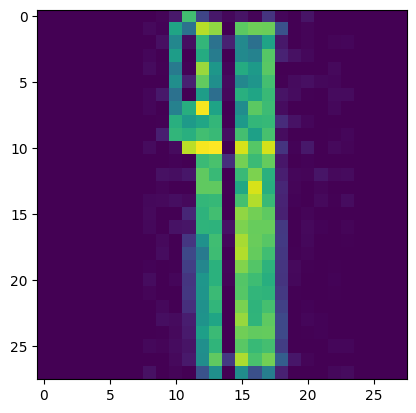

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

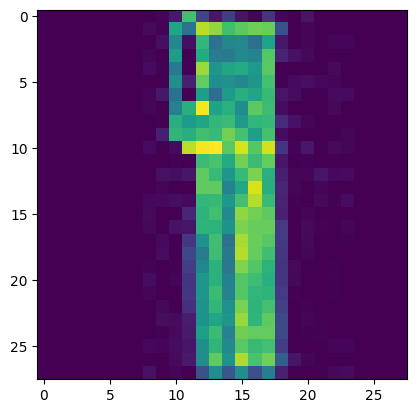

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

# With Batch Normalization layers and Dropout layers

In [ ]:
model = MLP(bn=True, dropout=True)
print(model)

MLP(
  (hidden_1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (hidden_2): Linear(in_features=512, out_features=512, bias=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=512, out_features=28, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.026719 	Validation Loss: 0.020675
Validation loss decreased (inf --> 0.020675).  Saving model ...
Epoch: 2 	Training Loss: 0.026673 	Validation Loss: 0.021568
Epoch: 3 	Training Loss: 0.026456 	Validation Loss: 0.019620
Validation loss decreased (0.020675 --> 0.019620).  Saving model ...
Epoch: 4 	Training Loss: 0.026402 	Validation Loss: 0.020822
Epoch: 5 	Training Loss: 0.026232 	Validation Loss: 0.019902
Epoch: 6 	Training Loss: 0.026104 	Validation Loss: 0.020681
Epoch: 7 	Training Loss: 0.025857 	Validation Loss: 0.019386
Validation loss decreased (0.019620 --> 0.019386).  Saving model ...
Epoch: 8 	Training Loss: 0.025787 	Validation Loss: 0.018909
Validation loss decreased (0.019386 --> 0.018909).  Saving model ...
Epoch: 9 	Training Loss: 0.025728 	Validation Loss: 0.018319
Validation loss decreased (0.018909 --> 0.018319).  Saving model ...
Epoch: 10 	Training Loss: 0.025542 	Validation Loss: 0.019893


Training process has finished.


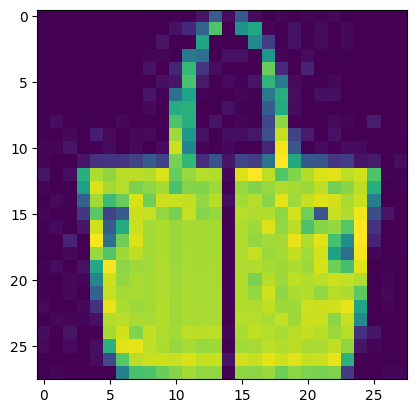

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

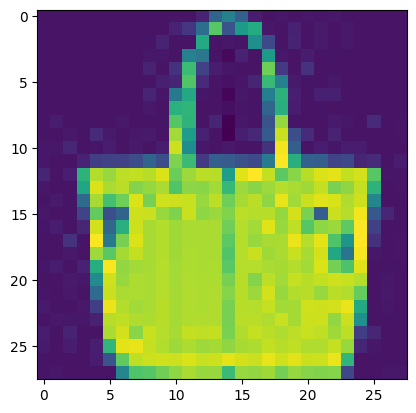

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

# Different activation functions, with Batch Normalization and No Dropout

In [ ]:
# Define the activation functions
sigmoid_func = nn.Sigmoid()
tanh_func = nn.Tanh()
leakyrelu_func = nn.LeakyReLU()

n_epochs = 10

activation_funcs = [sigmoid_func, tanh_func, leakyrelu_func]
for i, func in enumerate(activation_funcs):
  print(f"Training neural network with activation function {i+1}: {func.__class__.__name__}")
  
  model = MLP(bn=True, dropout=False, activation_func=func)
  
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    

print('\n')
print('Training process has finished.')

Training neural network with activation function 1: Sigmoid
Epoch: 1 	Training Loss: 0.032787 	Validation Loss: 0.021801
Epoch: 2 	Training Loss: 0.022385 	Validation Loss: 0.019720
Epoch: 3 	Training Loss: 0.020634 	Validation Loss: 0.018194
Epoch: 4 	Training Loss: 0.019655 	Validation Loss: 0.017623
Epoch: 5 	Training Loss: 0.018996 	Validation Loss: 0.018209
Epoch: 6 	Training Loss: 0.018615 	Validation Loss: 0.016495
Epoch: 7 	Training Loss: 0.018014 	Validation Loss: 0.016627
Epoch: 8 	Training Loss: 0.017743 	Validation Loss: 0.015862
Epoch: 9 	Training Loss: 0.017459 	Validation Loss: 0.015704
Epoch: 10 	Training Loss: 0.017286 	Validation Loss: 0.015252
Training neural network with activation function 2: Tanh
Epoch: 1 	Training Loss: 0.043152 	Validation Loss: 0.022417
Epoch: 2 	Training Loss: 0.022118 	Validation Loss: 0.019479
Epoch: 3 	Training Loss: 0.019977 	Validation Loss: 0.018291
Epoch: 4 	Training Loss: 0.018708 	Validation Loss: 0.017253
Epoch: 5 	Training Loss: 0.0

# Learning rate scheduling(Using Learning Rate Decay)

In [ ]:
model = MLP(bn=True)
print(model)


MLP(
  (activation_func): ReLU()
  (hidden_1): Linear(in_features=784, out_features=512, bias=True)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_2): Linear(in_features=512, out_features=512, bias=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=512, out_features=28, bias=True)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    scheduler.step()

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.037296 	Validation Loss: 0.022469
Validation loss decreased (inf --> 0.022469).  Saving model ...
Epoch: 2 	Training Loss: 0.023122 	Validation Loss: 0.019390
Validation loss decreased (0.022469 --> 0.019390).  Saving model ...
Epoch: 3 	Training Loss: 0.020979 	Validation Loss: 0.018377
Validation loss decreased (0.019390 --> 0.018377).  Saving model ...
Epoch: 4 	Training Loss: 0.019734 	Validation Loss: 0.017488
Validation loss decreased (0.018377 --> 0.017488).  Saving model ...
Epoch: 5 	Training Loss: 0.018835 	Validation Loss: 0.016837
Validation loss decreased (0.017488 --> 0.016837).  Saving model ...
Epoch: 6 	Training Loss: 0.018116 	Validation Loss: 0.016061
Validation loss decreased (0.016837 --> 0.016061).  Saving model ...
Epoch: 7 	Training Loss: 0.017543 	Validation Loss: 0.015679
Validation loss decreased (0.016061 --> 0.015679).  Saving model ...
Epoch: 8 	Training Loss: 0.017141 	Validation Loss: 0.016745
Epoch: 9 	Training Loss: 0.016729 

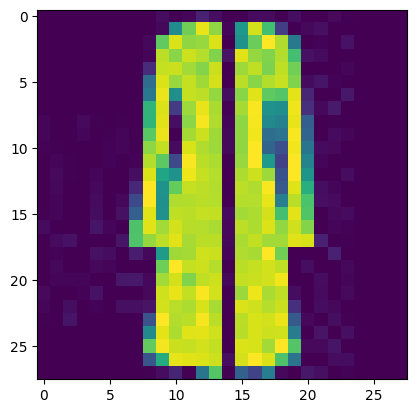

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

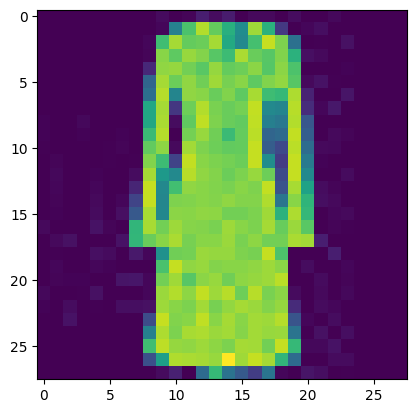

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

# L1 and L2 Regularization

In [ ]:
model = MLP()
print(model)

MLP(
  (activation_func): ReLU()
  (hidden_1): Linear(in_features=784, out_features=512, bias=True)
  (hidden_2): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=28, bias=True)
)


In [ ]:
# L1

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        l1_reg = torch.tensor(0.)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l1_reg += torch.norm(param, 1)
        loss += 0.001 * l1_reg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 2.647001 	Validation Loss: 0.070237
Validation loss decreased (inf --> 0.070237).  Saving model ...
Epoch: 2 	Training Loss: 0.094189 	Validation Loss: 0.066448
Validation loss decreased (0.070237 --> 0.066448).  Saving model ...
Epoch: 3 	Training Loss: 0.085564 	Validation Loss: 0.066091
Validation loss decreased (0.066448 --> 0.066091).  Saving model ...
Epoch: 4 	Training Loss: 0.084189 	Validation Loss: 0.065948
Validation loss decreased (0.066091 --> 0.065948).  Saving model ...
Epoch: 5 	Training Loss: 0.083441 	Validation Loss: 0.065991
Epoch: 6 	Training Loss: 0.083096 	Validation Loss: 0.066024
Epoch: 7 	Training Loss: 0.082874 	Validation Loss: 0.065966
Epoch: 8 	Training Loss: 0.082753 	Validation Loss: 0.065999
Epoch: 9 	Training Loss: 0.082671 	Validation Loss: 0.065929
Validation loss decreased (0.065948 --> 0.065929).  Saving model ...
Epoch: 10 	Training Loss: 0.082613 	Validation Loss: 0.065907
Validation loss decreased (0.065929 --> 0.065907)

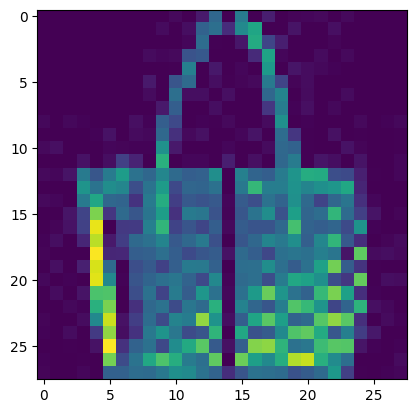

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

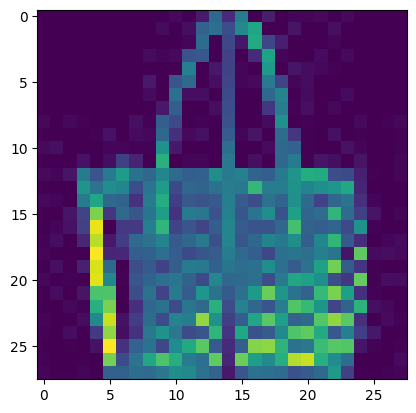

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

In [ ]:
model = MLP()

In [ ]:
# L2

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        l2_reg = torch.tensor(0.)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, 2)**2
        loss += 0.001 * l2_reg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.356331 	Validation Loss: 0.032578
Validation loss decreased (inf --> 0.032578).  Saving model ...
Epoch: 2 	Training Loss: 0.260471 	Validation Loss: 0.028559
Validation loss decreased (0.032578 --> 0.028559).  Saving model ...
Epoch: 3 	Training Loss: 0.201197 	Validation Loss: 0.027085
Validation loss decreased (0.028559 --> 0.027085).  Saving model ...
Epoch: 4 	Training Loss: 0.157966 	Validation Loss: 0.026264
Validation loss decreased (0.027085 --> 0.026264).  Saving model ...
Epoch: 5 	Training Loss: 0.126177 	Validation Loss: 0.025862
Validation loss decreased (0.026264 --> 0.025862).  Saving model ...
Epoch: 6 	Training Loss: 0.102753 	Validation Loss: 0.025460
Validation loss decreased (0.025862 --> 0.025460).  Saving model ...
Epoch: 7 	Training Loss: 0.085428 	Validation Loss: 0.025300
Validation loss decreased (0.025460 --> 0.025300).  Saving model ...
Epoch: 8 	Training Loss: 0.072625 	Validation Loss: 0.025265
Validation loss decreased (0.02530

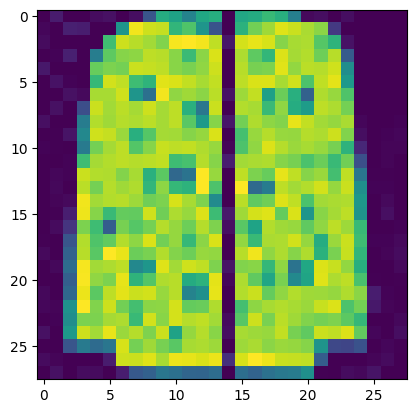

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

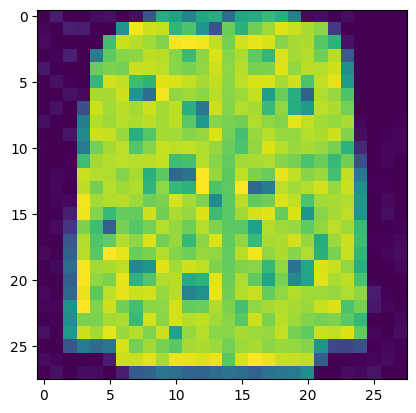

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

# Different Weight initialization

In [ ]:
# Zero initialization
model_1 = MLP(bn=True)
nn.init.zeros_(model_1.hidden_1.weight)
nn.init.zeros_(model_1.hidden_2.weight)

# Random initialization
model_2 = MLP(bn=True)
nn.init.normal_(model_2.hidden_1.weight, mean=0.0, std=1.0)
nn.init.normal_(model_2.hidden_2.weight, mean=0.0, std=1.0)

# He initialization
model_3 = MLP(bn=True)
nn.init.kaiming_normal_(model_3.hidden_1.weight, mode='fan_in', nonlinearity='relu')
nn.init.kaiming_normal_(model_3.hidden_2.weight, mode='fan_in', nonlinearity='relu')

# Xavier initialization
model_4 = MLP(bn=True)
nn.init.xavier_normal_(model_4.hidden_1.weight, gain=1.0)
nn.init.xavier_normal_(model_4.hidden_2.weight, gain=1.0)

Parameter containing:
tensor([[-0.0275,  0.0406, -0.0166,  ..., -0.0180,  0.0239,  0.0118],
        [-0.0041,  0.0272, -0.0703,  ..., -0.0135, -0.0793, -0.0582],
        [ 0.0012,  0.0672, -0.0087,  ...,  0.0028,  0.0282, -0.0126],
        ...,
        [-0.0017,  0.0168, -0.0137,  ...,  0.0565, -0.0099,  0.0393],
        [-0.0811,  0.0844,  0.0055,  ..., -0.0230, -0.0664,  0.1054],
        [ 0.0159,  0.0526,  0.0040,  ..., -0.0332,  0.0282,  0.0765]],
       requires_grad=True)

In [ ]:
n_epochs = 10

models = [model_1, model_2, model_3, model_4]
for i, model in enumerate(models):
  print(f"Training neural network with model_{i+1}...")
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

  valid_loss_min = np.Inf # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss = 0.0
      valid_loss = 0.0
  
      model.train() 
      for data, target in train_dataloader:
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()*data.size(0)

      model.eval()
      for data, target in valid_dataloader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

          
      # calculate average loss over an epoch
      train_loss = train_loss/len(train_dataloader.dataset)
      valid_loss = valid_loss/len(valid_dataloader.dataset)
      
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch+1, 
          train_loss,
          valid_loss
          ))

  print('Training process has finished.')
  print('\n')

Training neural network with model_1...
Epoch: 1 	Training Loss: 0.039050 	Validation Loss: 0.021025
Epoch: 2 	Training Loss: 0.020873 	Validation Loss: 0.018689
Epoch: 3 	Training Loss: 0.018142 	Validation Loss: 0.016478
Epoch: 4 	Training Loss: 0.016925 	Validation Loss: 0.014993
Epoch: 5 	Training Loss: 0.016142 	Validation Loss: 0.014970
Epoch: 6 	Training Loss: 0.015433 	Validation Loss: 0.014732
Epoch: 7 	Training Loss: 0.015025 	Validation Loss: 0.013826
Epoch: 8 	Training Loss: 0.014625 	Validation Loss: 0.013624
Epoch: 9 	Training Loss: 0.014248 	Validation Loss: 0.013872
Epoch: 10 	Training Loss: 0.014043 	Validation Loss: 0.013128
Training process has finished.


Training neural network with model_2...
Epoch: 1 	Training Loss: 0.053779 	Validation Loss: 0.031809
Epoch: 2 	Training Loss: 0.030827 	Validation Loss: 0.026416
Epoch: 3 	Training Loss: 0.027579 	Validation Loss: 0.024746
Epoch: 4 	Training Loss: 0.026180 	Validation Loss: 0.023365
Epoch: 5 	Training Loss: 0.02543

# Different Optimizers

In [ ]:
# ADAM

model = MLP()
criterion = nn.MSELoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer_adam.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_adam.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.282509 	Validation Loss: 0.026955
Validation loss decreased (inf --> 0.026955).  Saving model ...
Epoch: 2 	Training Loss: 0.027670 	Validation Loss: 0.026071
Validation loss decreased (0.026955 --> 0.026071).  Saving model ...
Epoch: 3 	Training Loss: 0.026943 	Validation Loss: 0.025415
Validation loss decreased (0.026071 --> 0.025415).  Saving model ...
Epoch: 4 	Training Loss: 0.026375 	Validation Loss: 0.026066
Epoch: 5 	Training Loss: 0.025963 	Validation Loss: 0.025167
Validation loss decreased (0.025415 --> 0.025167).  Saving model ...
Epoch: 6 	Training Loss: 0.025769 	Validation Loss: 0.026523
Epoch: 7 	Training Loss: 0.025922 	Validation Loss: 0.025531
Epoch: 8 	Training Loss: 0.025730 	Validation Loss: 0.025286
Epoch: 9 	Training Loss: 0.025706 	Validation Loss: 0.025583
Epoch: 10 	Training Loss: 0.025723 	Validation Loss: 0.025064
Validation loss decreased (0.025167 --> 0.025064).  Saving model ...


Training process has finished.


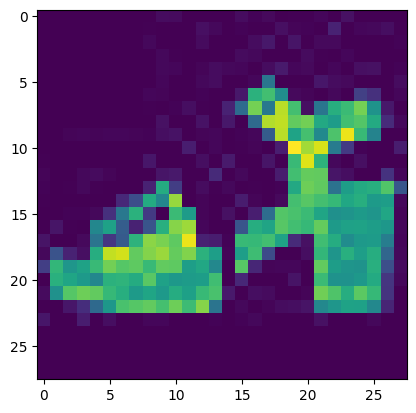

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

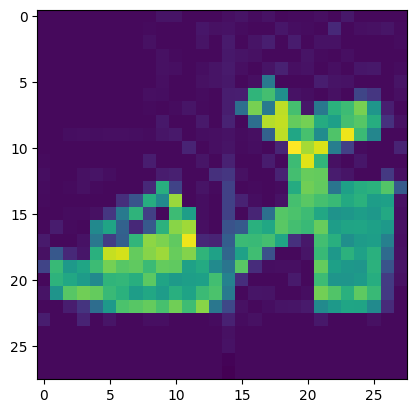

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

In [ ]:
# ADAGARD

model = MLP()
criterion = nn.MSELoss()
optimizer_adagard = torch.optim.Adagrad(model.parameters(), lr=0.01)

n_epochs = 10
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer_adagard.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_adagard.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.221920 	Validation Loss: 0.022743
Validation loss decreased (inf --> 0.022743).  Saving model ...
Epoch: 2 	Training Loss: 0.020634 	Validation Loss: 0.019196
Validation loss decreased (0.022743 --> 0.019196).  Saving model ...
Epoch: 3 	Training Loss: 0.018345 	Validation Loss: 0.017749
Validation loss decreased (0.019196 --> 0.017749).  Saving model ...
Epoch: 4 	Training Loss: 0.017144 	Validation Loss: 0.016578
Validation loss decreased (0.017749 --> 0.016578).  Saving model ...
Epoch: 5 	Training Loss: 0.016364 	Validation Loss: 0.016009
Validation loss decreased (0.016578 --> 0.016009).  Saving model ...
Epoch: 6 	Training Loss: 0.015754 	Validation Loss: 0.015805
Validation loss decreased (0.016009 --> 0.015805).  Saving model ...
Epoch: 7 	Training Loss: 0.015255 	Validation Loss: 0.015164
Validation loss decreased (0.015805 --> 0.015164).  Saving model ...
Epoch: 8 	Training Loss: 0.014851 	Validation Loss: 0.014749
Validation loss decreased (0.01516

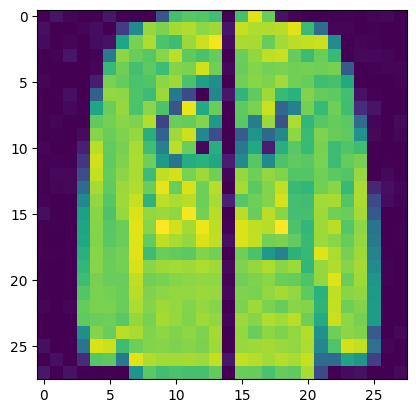

In [ ]:
data, target = next(iter(valid_dataloader))
model.eval()
output = model(data)
data = data.reshape(64, 28, 28)
plt.imshow(data[0, :, :].detach().numpy())

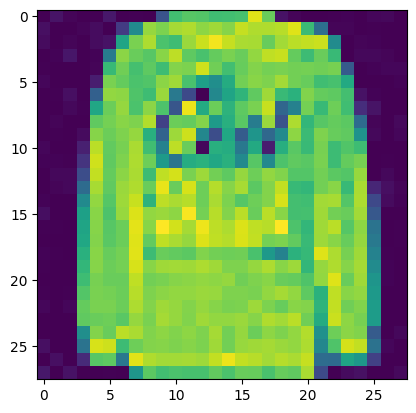

In [ ]:
data[0:, :, 14] = output[0, :]
plt.imshow(data[0, :, :].detach().numpy())

# Early Stopping

In [21]:
model = MLP(bn=True)

nn.init.zeros_(model.hidden_1.weight)
nn.init.zeros_(model.hidden_2.weight)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

n_epochs = 20
valid_loss_min = np.Inf 

patience = 2 # set the number of epochs to wait before stopping
counter = 0

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
 
    model.train() 
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_dataloader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

        
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease

    # stop training if validation loss has not decreased for a certain number of epochs(patience)
    if counter >= patience:
        print('Early stopping')
        break

print('\n')
print('Training process has finished.')

Epoch: 1 	Training Loss: 0.044968 	Validation Loss: 0.021248
Validation loss decreased (inf --> 0.021248).  Saving model ...
Epoch: 2 	Training Loss: 0.021463 	Validation Loss: 0.019451
Validation loss decreased (0.021248 --> 0.019451).  Saving model ...
Epoch: 3 	Training Loss: 0.020003 	Validation Loss: 0.017684
Validation loss decreased (0.019451 --> 0.017684).  Saving model ...
Epoch: 4 	Training Loss: 0.018798 	Validation Loss: 0.017770
Epoch: 5 	Training Loss: 0.018112 	Validation Loss: 0.016494
Validation loss decreased (0.017684 --> 0.016494).  Saving model ...
Epoch: 6 	Training Loss: 0.017354 	Validation Loss: 0.016562
Epoch: 7 	Training Loss: 0.016858 	Validation Loss: 0.016136
Validation loss decreased (0.016494 --> 0.016136).  Saving model ...
Epoch: 8 	Training Loss: 0.016572 	Validation Loss: 0.015428
Validation loss decreased (0.016136 --> 0.015428).  Saving model ...
Epoch: 9 	Training Loss: 0.016158 	Validation Loss: 0.015124
Validation loss decreased (0.015428 --> 0.